## Configuración de las capas del Generador: 28px, 64px

In [1]:
import os
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torchvision import transforms

In [2]:
print(os.getcwd())
currentPath = os.getcwd().split('/')

indexOf = currentPath.index('CDCGAN')
rootPath = '/'.join(currentPath[:indexOf+1])
os.chdir(rootPath)
root = os.getcwd()

print(os.getcwd())

/workspace/CDCGAN/packages/arquitectures/networks
/workspace/CDCGAN


In [3]:
from packages.arquitectures.networks.Generator import GeneratorMannager
from packages.dataHandlers.datasetMannager import datasetMannager

In [4]:
def _inputGen(in_channels, out_channels, kernel_size, stride, padding):
    return nn.Sequential(
        nn.ConvTranspose2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride, padding=padding, bias=False),
        nn.BatchNorm2d(out_channels),
        nn.ReLU()
    )

def _blockGen(in_channels, out_channels, kernel_size, stride, padding):
    return nn.Sequential(
        nn.ConvTranspose2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride, padding=padding, bias=False),
        nn.BatchNorm2d(out_channels),
        nn.ReLU()
    )

def _outputGen(in_channels, out_channels,kernel_size, stride, padding):
    return nn.Sequential(
        nn.ConvTranspose2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride, padding=padding, bias=False), 
        nn.Tanh()	
    )

input = torch.Size([128, 100]) - torch.Size([128, 24])
----------------------
_l0=torch.Size([128, 512, 5, 5])
_l1=torch.Size([128, 256, 8, 8])
_l2=torch.Size([128, 128, 16, 16])
_l3=torch.Size([128, 64, 32, 32])
_l4=torch.Size([128, 1, 64, 64])
----------------------
output = torch.Size([1, 64, 64])


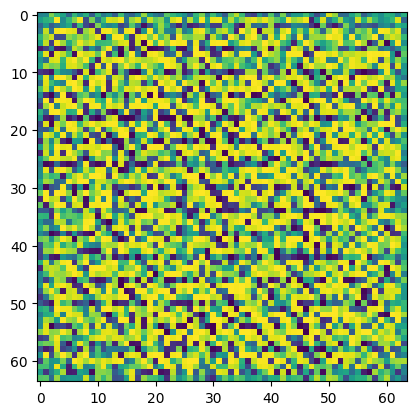

Label: v


In [5]:
class ConditionalGenerator64(nn.Module):
    def __init__(self, input_size=100, labels=10):
        super(ConditionalGenerator64, self).__init__()
        self.layer_x = _inputGen(input_size, 256,kernel_size=5, stride=1, padding=0) 
        self.layer_y = _inputGen(labels, 256, kernel_size=5, stride=1, padding=0)    

        self.layer_1 = _blockGen(512, 256, kernel_size=2, stride=2, padding=1)    
        self.layer_2 = _blockGen(256, 128, kernel_size=4, stride=2, padding=1)   
        self.layer_3 = _blockGen(128, 64, kernel_size=4, stride=2, padding=1)
        self.layer_4 = _outputGen(64, 1, kernel_size=4, stride=2, padding=1)    
   
    def forward(self, x, y):
        print(f"input = {x.shape} - {y.shape}")
        print("----------------------")
        
        x, y = x.view(x.shape[0], x.shape[1], 1, 1), y.view(y.shape[0], y.shape[1], 1, 1)
        lx, ly = self.layer_x(x), self.layer_y(y)
    
        l0 = torch.cat([lx, ly], dim=1)
        print(f"_l0={l0.shape}")

        l1 = self.layer_1(l0)  
        print(f"_l1={l1.shape}")

        l2 = self.layer_2(l1)
        print(f"_l2={l2.shape}")

        l3 = self.layer_3(l2)
        print(f"_l3={l3.shape}")

        l4 = self.layer_4(l3)
        print(f"_l4={l4.shape}")

        print("----------------------")
        print(f"output = {l4.shape[1:]}")

        return l4

DATASET_NAME = "LETTERS"
BATCH_SIZE = 128
IMG_CHANNELS = 1
IMG_SIZE = 64
Z_SIZE = 100

transform = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.Grayscale(num_output_channels=IMG_CHANNELS),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5]),
])

dataHandler_64 = datasetMannager(transform, BATCH_SIZE, DATASET_NAME)
data_module_64 = dataHandler_64.getDataModule()
# data_module.displaySamples()

DATALOADER_64 = data_module_64.getTrainDataLoader()
UNIQUE_LABELS = data_module_64.getUniqueLabels()
LABELS_COUNT = UNIQUE_LABELS.shape[0]

# Example of usage
z = torch.randn(BATCH_SIZE,Z_SIZE)
fake_label = (torch.rand(BATCH_SIZE, 1)*LABELS_COUNT).type(torch.LongTensor).squeeze()
ONEHOT = torch.zeros(LABELS_COUNT, LABELS_COUNT).scatter_(1, UNIQUE_LABELS.view(LABELS_COUNT,1), 1) 

gen_64 = ConditionalGenerator64(Z_SIZE, LABELS_COUNT)
fake_image = gen_64(z, ONEHOT[fake_label])
data_module_64.displayImage(fake_image.detach(), fake_label)

input = torch.Size([128, 100]) - torch.Size([128, 24])
----------------------
_l0 = torch.Size([128, 256, 3, 3])
_l1 = torch.Size([128, 128, 7, 7])
_l2 = torch.Size([128, 64, 14, 14])
_l3 = torch.Size([128, 1, 28, 28])
----------------------
output = torch.Size([1, 28, 28])


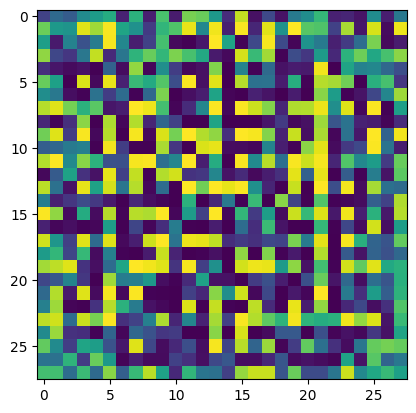

Label: z


In [6]:
class ConditionalGenerator28(nn.Module):
    def __init__(self, input_size=100, labels=10):
        super(ConditionalGenerator28, self).__init__()
        self.layer_x = _inputGen(input_size, 128,kernel_size=3, stride=1, padding=0)	# input: (100, 1, 1)	=>	out: (128, 3, 3)
        self.layer_y = _inputGen(labels, 128, kernel_size=3, stride=1, padding=0)		# input: (10, 1, 1) 	=>	out: (128, 3, 3)

        self.layer_1 = _blockGen(256, 128, kernel_size=3, stride=2, padding=0)		# input: (256, 3, 3)	=>	out: (128, 7, 7)
        self.layer_2 = _blockGen(128, 64, kernel_size=4, stride=2, padding=1)			# input: (128, 7, 7)	=>	out: (64, 14, 14)
        self.layer_3 = _outputGen(64, 1, kernel_size=4, stride=2, padding=1)			# input: (64, 14, 14)	=>	out: (1, 28, 28)
        
    def forward(self, x, y):
        print(f"input = {x.shape} - {y.shape}")
        print("----------------------")
        x, y = x.view(x.shape[0], x.shape[1], 1, 1), y.view(y.shape[0], y.shape[1], 1, 1)

        lx, ly = self.layer_x(x), self.layer_y(y)
        l0 = torch.cat([lx,ly], dim=1)
        print(f"_l0 = {l0.shape}")
    
        l1 = self.layer_1(l0) # input size : (batch_size, 256, 3, 3)
        print(f"_l1 = {l1.shape}") 
        
        l2 = self.layer_2(l1)
        print(f"_l2 = {l2.shape}")
        
        l3 = self.layer_3(l2)
        print(f"_l3 = {l3.shape}")

        print("----------------------")
        print(f"output = {l3.shape[1:]}")

        return l3

DATASET_NAME = "LETTERS"
BATCH_SIZE = 128
IMG_CHANNELS = 1
IMG_SIZE = 28
Z_SIZE = 100

transform = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.Grayscale(num_output_channels=IMG_CHANNELS),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5]),
])

dataHandler_28 = datasetMannager(transform, BATCH_SIZE, DATASET_NAME)
data_module_28 = dataHandler_28.getDataModule()
# data_module.displaySamples()
DATALOADER_28 = data_module_28.getTrainDataLoader()
UNIQUE_LABELS = data_module_28.getUniqueLabels()
LABELS_COUNT = UNIQUE_LABELS.shape[0]

z = torch.randn(BATCH_SIZE,Z_SIZE)
fake_label = (torch.rand(BATCH_SIZE, 1)*LABELS_COUNT).type(torch.LongTensor).squeeze()
ONEHOT = torch.zeros(LABELS_COUNT, LABELS_COUNT).scatter_(1, UNIQUE_LABELS.view(LABELS_COUNT,1), 1) 

gen_28 = ConditionalGenerator28(Z_SIZE, LABELS_COUNT)
fake_image = gen_28(z, ONEHOT[fake_label])
data_module_64.displayImage(fake_image.detach(), fake_label)